### 2. Active Learning Using Support Vector Machines 

#### (a) Download the banknote authentication Data Set from: https://archive.ics.uci.edu/ml/datasets/banknote+authentication. Choose 472 data points randomly as the test set, and the remaining 900 points as the training set. This is a binary classification problem.

In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score
import random
import warnings 
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('data.txt',header=None,names=['var','skew','curt','entr','class'])

In [3]:
test=df.sample(472)
index_test=test.index

In [4]:
train= df.drop(index=index_test)

In [5]:
y_test=test.iloc[:,-1:]
x_test=test.iloc[:,:-1]
y_train=train.iloc[:,-1:]
x_train=train.iloc[:,:-1]
x_train=x_train.reset_index(drop=True)
y_train=y_train.reset_index(drop=True)
x_test=x_test.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)

### (b) Repeat each of the following two procedures 50 times. You will have 50 errors for 90 SVMs per each procedure.

#### i. Train a SVM with a pool of 10 randomly selected data points from the training set using linear kernel and L1 penalty. Select the penalty parameter using 10-fold cross validation.2 Repeat this process by adding 10 other randomly selected data points to the pool, until you use all the 900 points. Do NOT replace the samples back into the training set at each step. Calculate the test error for each SVM. You will have 90 SVMs that were trained using 10,20, 30, ... , 900 data points and their 90 test errors. You have implemented passive learning.


In [6]:

df_acs1=pd.DataFrame()
for x in range(0,50):
    acs1=[]
    x_tr=pd.DataFrame()
    y_tr=pd.DataFrame()
    skf=StratifiedKFold(n_splits=90)
    cv=5
    for train_index, tr_index_10 in skf.split(x_train, y_train):
            #print(type(x_tr))
            x_tr=pd.concat([x_tr,x_train.iloc[tr_index_10,:]])
            #print(x_tr)
            y_tr=pd.concat([y_tr,y_train.iloc[tr_index_10]])
           # print(y_tr)
            parameters = [{'C': [0.1,0.001,1, 10, 100, 1000],'max_iter':[2000]} ]
            model = GridSearchCV(svm.LinearSVC(penalty='l1',dual=False),parameters,cv=cv)
            cv=10
            model.fit(x_tr, y_tr.values.ravel())
    
            #calculating train parameters
            pred_y = model.predict(x_test)
            acs1.append(accuracy_score(y_test, pred_y)) 
    df_acs1=pd.concat([df_acs1,pd.DataFrame(acs1)],axis=1)

#### ii. Train a SVM with a pool of 10 randomly selected data points from the training set3 using linear kernel and L1 penalty. Select the parameters of the SVM with 10-fold cross validation. Choose the 10 closest data points in the training set to the hyperplane of the SVM4 and add them to the pool. Do not replace the samples back into the training set. Train a new SVM using the pool.Repeat this process until all training data is used. You will have 90 SVMs that were trained using 10, 20, 30,..., 900 data points and their 90 test errors.You have implemented active learning.

In [7]:
df_acs=pd.DataFrame()
for x in range(0,50):
    test=df.sample(472)
    index_test=test.index
    train= df.drop(index=index_test)
    y_test=test.iloc[:,-1:]
    x_test=test.iloc[:,:-1]
    y_train=train.iloc[:,-1:]
    x_train=train.iloc[:,:-1]
    x_tr=pd.DataFrame()
    y_tr=pd.DataFrame()
    acs=[]
    skf=StratifiedKFold(n_splits=90)
    cv=2
    for train_index, tr_index_10 in skf.split(x_train, y_train):
       # print(tr_index_10)
        x_tr=x_train.iloc[tr_index_10,:]
        y_tr=y_train.iloc[tr_index_10,:]
        #print(y_tr)
        break
    for x in range(0,90):
        #print(x)
        x_train=x_train.reset_index(drop=True)
        y_train=y_train.reset_index(drop=True)
        x_test=x_test.reset_index(drop=True)
        y_test=y_test.reset_index(drop=True)
        parameters = [{'C': [0.1,0.001,1, 10, 100, 1000],'max_iter':[2000]} ]
        model = GridSearchCV(svm.LinearSVC(penalty='l1',dual=False),parameters,cv=cv)
        cv=10
        #print('Grid')
        model.fit(x_tr, y_tr.values.ravel())           
        dist=pd.DataFrame(abs(model.decision_function(x_train)))
        dist_sort= dist.sort_values(0) 
        dist_sort=dist_sort.iloc[0:10,:]
        indexes=dist_sort.index

        #print(y_train.iloc[230,:])
        x_tr=pd.concat([x_tr,x_train.iloc[indexes,:]],axis=0)
        y_tr=pd.concat([y_tr,y_train.iloc[indexes,:]],axis=0)
        x_tr.reset_index(drop=True,inplace=True)
        y_tr.reset_index(drop=True,inplace=True)
        x_train=x_train.drop(index=indexes) 
        y_train=y_train.drop(index=indexes)
        #calculating train parameters
        pred_y = model.predict(x_test)
        acs.append(accuracy_score(y_test, pred_y))
    df_acs=pd.concat([df_acs,pd.DataFrame(acs)],axis=1)

#### c) Average the 50 test errors for each of the incrementally trained 90 SVMs in 2(b)i and 2(b)ii. By doing so, you are performing a Monte Carlo simulation. Plot average test error versus number of training instances for both active and passive learners on the same figure and report your conclusions. Here, you are actually obtaining a learning curve by Monte-Carlo simulation.

active performs well as it reaches minimum error rate faster than passive learning 

In [8]:
avg2=np.mean(df_acs,axis=1)
avg1=np.mean(df_acs1,axis=1)

Text(0,0.5,'Average Test Error')

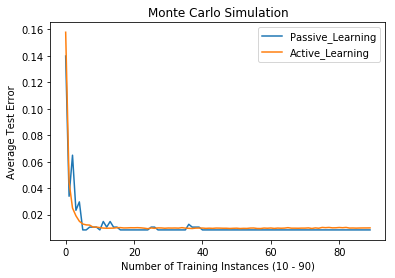

In [10]:
p = pd.DataFrame({'Passive_Learning':1-avg1, 'Active_Learning':1-avg2})

ax = p.plot(style='-',title='Monte Carlo Simulation')
#ax.tick_params()
#ax.yscale(0.08)
ax.set_xlabel("Number of Training Instances (10 - 90)")
ax.set_ylabel("Average Test Error")
